In [1]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import riskfolio as rp
import itertools
import statsmodels.api as sm

In [2]:
#make sure the number of bonds and stocks match each other in value
stock_tickers = ['AAPL','GOOGL','F','T','TSLA','MSFT','AMZN','NVDA','NFLX']
bond_tickers = ['BND','HYG','TIP','IEF','LQD','SHY','AGG','MUB','HYG','TLT']

np.random.shuffle(stock_tickers)
np.random.shuffle(bond_tickers)

start_date = '2020-11-03'
end_date = '2023-12-16'

bond_df = yf.download(tickers=bond_tickers, start=start_date, end=end_date)['Close']
stock_df = yf.download(tickers=stock_tickers, start=start_date, end=end_date)['Close']

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  9 of 9 completed


In [3]:
# the pct_change().dropna() is the same as the expected return of the asset
# The rest of the model is portfolio optimization with 'l' being a individuals level of risk aversion

returns_stocks = stock_df.pct_change().dropna()
returns_bonds = bond_df.pct_change().dropna()

assets = stock_df.copy()
debt = bond_df.copy()
port = rp.Portfolio(returns=assets)

method_mu = 'hist'
method_cov = 'hist'
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
hist = True
rf = 0.05
l = 5

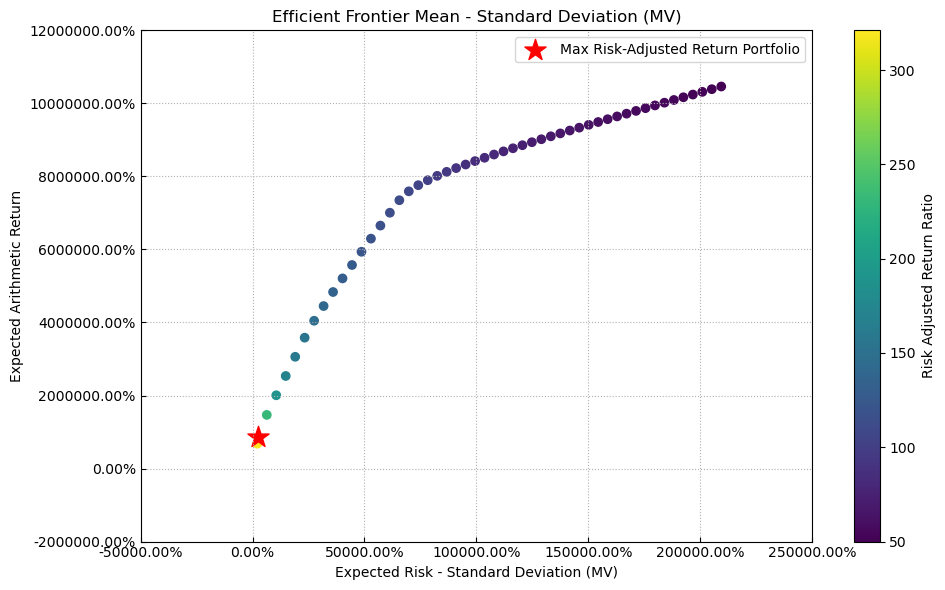

In [4]:
# The following will show the individuals expected return based on risk-aversion(l)

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
points = 50
frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
label = 'Max Risk-Adjusted Return Portfolio'

ax = rp.plot_frontier(w_frontier=frontier, mu=port.mu, cov=port.cov, returns=port.returns, rm=rm, rf=rf, alpha=0.05, cmap='viridis', w=w, label=label, marker='*', s=16, c='r', height=6, width=10, ax=None)
ax.legend()

plt.show()

In [5]:
# covariance of all assets bonds and stocks
cov_matrix_stocks_bonds = np.cov(returns_stocks.T, returns_bonds.T)
print(f'Covariance Matrix between Stocks and Bonds:\n{cov_matrix_stocks_bonds}')


Covariance Matrix between Stocks and Bonds:
[[ 3.11390915e-04  2.51703103e-04  1.71942670e-04  2.31269118e-04
   2.21772932e-04  2.49676215e-04  3.61049751e-04  4.83910745e-05
   3.37641698e-04  1.41270273e-05  1.37538628e-05  5.60116401e-05
   1.01506464e-05  3.37445963e-05  8.46383640e-06  2.40600327e-06
   1.41774074e-05  1.52276845e-05]
 [ 2.51703103e-04  5.49077573e-04  1.91318713e-04  3.07379851e-04
   2.77303966e-04  3.73864572e-04  4.56298333e-04  5.44388399e-05
   3.91636515e-04  2.43875509e-05  2.35722242e-05  7.25972112e-05
   2.08492639e-05  4.92584520e-05  1.29131770e-05  5.35616320e-06
   2.35125876e-05  3.30467965e-05]
 [ 1.71942670e-04  1.91318713e-04  7.16915051e-04  1.82036901e-04
   1.52657265e-04  2.32571910e-04  3.30650103e-04  1.12148555e-04
   3.61372684e-04  1.03658834e-05  9.72746473e-06  7.26397193e-05
   1.31926204e-06  2.82317653e-05  9.69439893e-06  1.21702122e-06
   1.26340082e-05 -5.81309352e-06]
 [ 2.31269118e-04  3.07379851e-04  1.82036901e-04  3.928590

In [6]:
#The following code is experimental and very hard to check in terms of accuracy


risk_free_rate = 0.05

combinations = list(itertools.product(stock_tickers, bond_tickers))

best_expected_return = -float('inf')
best_sharpe_ratio = -float('inf')
best_expected_return_combinations = []
best_sharpe_ratio_combinations = []

returns = {}

# Calculate returns for all combinations and find the best ones
for combination in combinations:
    stock, bond = combination
    subset_returns_stocks = returns_stocks[stock]
    subset_returns_bonds = returns_bonds[bond]
    combined_returns = subset_returns_stocks - subset_returns_bonds

    excess_returns = combined_returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std()

    returns[combination] = combined_returns.mean()

    if sharpe_ratio > best_sharpe_ratio:
        best_sharpe_ratio = sharpe_ratio
        best_sharpe_ratio_combinations = [combination]
    elif sharpe_ratio == best_sharpe_ratio:
        best_sharpe_ratio_combinations.append(combination)

    if returns[combination] > best_expected_return:
        best_expected_return = returns[combination]
        best_expected_return_combinations = [combination]
    elif returns[combination] == best_expected_return:
        best_expected_return_combinations.append(combination)

In [7]:
# this will potenitally return the best combination of assets based on the individuals level
# of risk aversion
if best_sharpe_ratio >= best_expected_return:
    print('Combinations that maximize Sharpe ratio:')
    for combination in best_sharpe_ratio_combinations:
        print('Combination:', combination)
    print('Max Sharpe Ratio:', best_sharpe_ratio)

    print('Combinations that maximize expected returns:')
    for combination in best_expected_return_combinations:
        print('Combination:', combination)
    print('Max Expected Returns:', best_expected_return)
else:
    print('Combinations that maximize expected returns:')
    for combination in best_expected_return_combinations:
        print('Combination:', combination)
    print('Max Expected Returns:', best_expected_return)

    print('Combinations that maximize Sharpe ratio:')
    for combination in best_sharpe_ratio_combinations:
        print('Combination:', combination)
    print('Max Sharpe Ratio:', best_sharpe_ratio)

Combinations that maximize expected returns:
Combination: ('NVDA', 'TLT')
Max Expected Returns: 0.0027576344256302256
Combinations that maximize Sharpe ratio:
Combination: ('TSLA', 'TLT')
Max Sharpe Ratio: -1.2464697533673645
